In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [4]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

In [5]:
series = pd.read_csv("weekly-closings-of-the-dowjones-.csv")['Close']

In [6]:
series.head()

0    890.19
1    901.80
2    888.51
3    887.78
4    858.43
Name: Close, dtype: float64

Results of Dickey-Fuller Test:
Test Statistic                  -1.314625
p-value                          0.622455
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


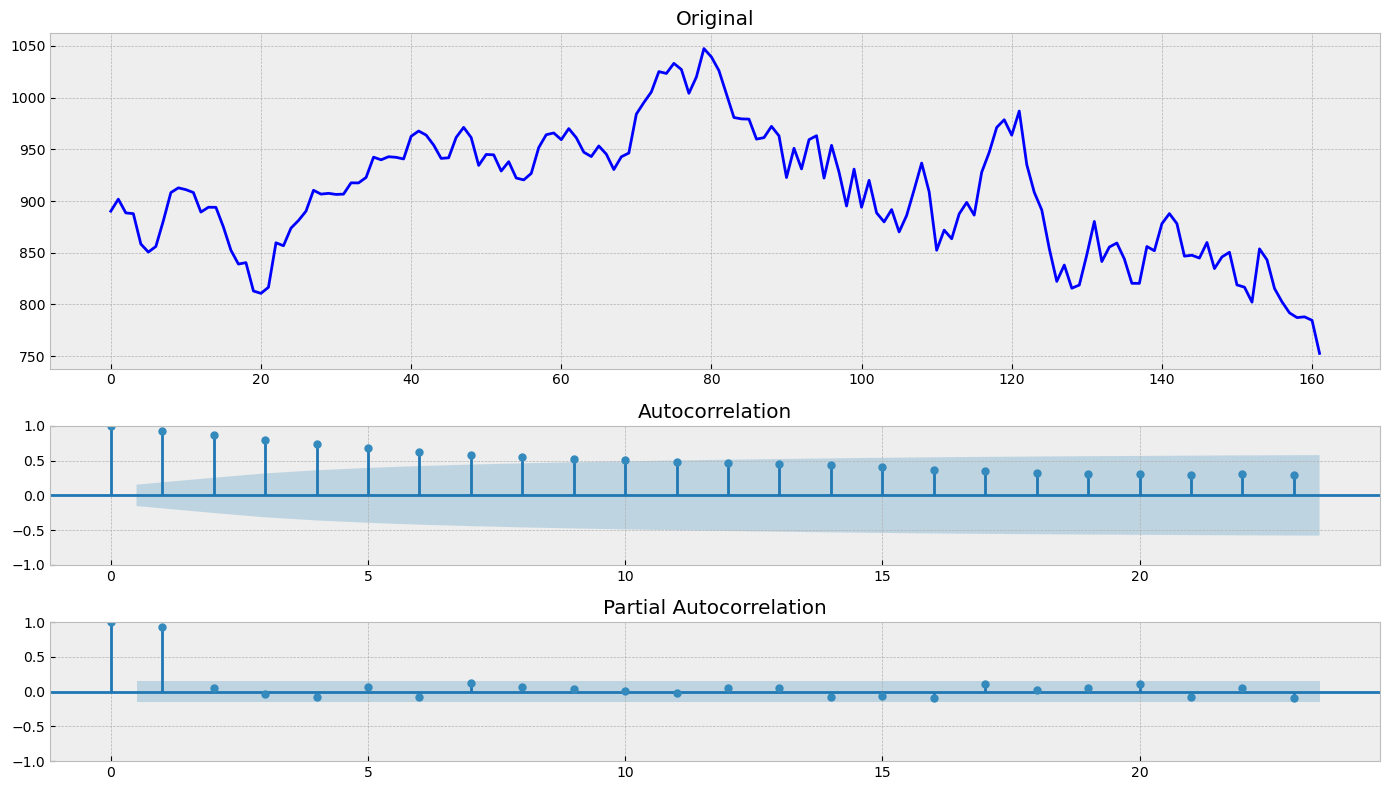

In [7]:
tsplot(series)

In [8]:
stat_series = series.copy()

In [9]:
stat_series = np.diff(stat_series, 1)

Results of Dickey-Fuller Test:
Test Statistic                -1.302521e+01
p-value                        2.407586e-24
#Lags Used                     0.000000e+00
Number of Observations Used    1.600000e+02
Critical Value (1%)           -3.471896e+00
Critical Value (5%)           -2.879780e+00
Critical Value (10%)          -2.576495e+00
dtype: float64


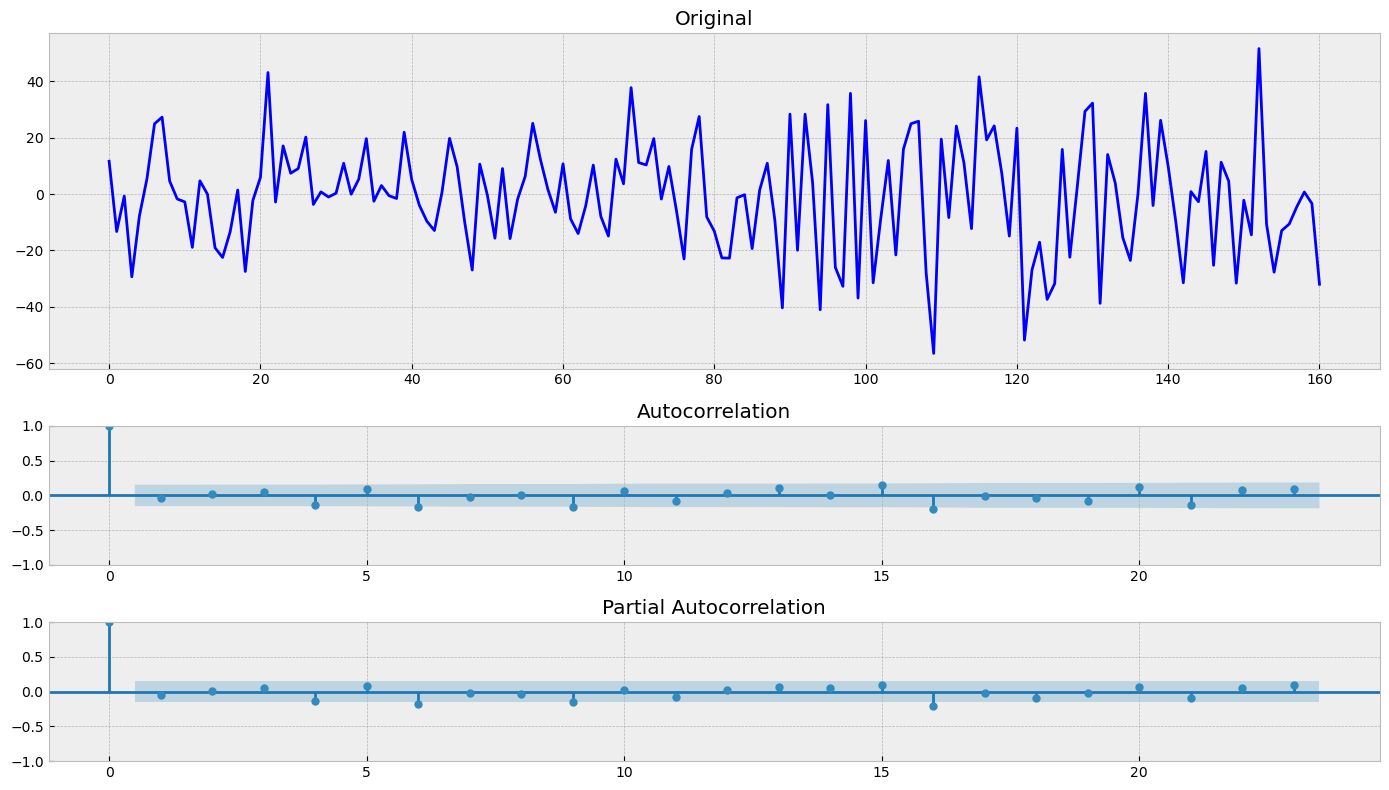

In [10]:
tsplot(stat_series)

# Нестационарный ряд

# Скользящее среднее (MA)
Начнем моделирование с наивного предположения - "завтра будет, как вчера", но вместо просто предсказания вида $\hat{y}_{t} = y_{t-1}$ будем считать, что будущее значение переменной зависит от среднего $n$ её предыдущих значений

$\hat{y}_{t} = \frac{1}{k} \displaystyle\sum^{k-1}_{n=0} y_{t-n}$

В данном случае $\hat{y}_{t}$ называется скользящей средней

In [11]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

In [12]:
ma_series = moving_average(series, 10)

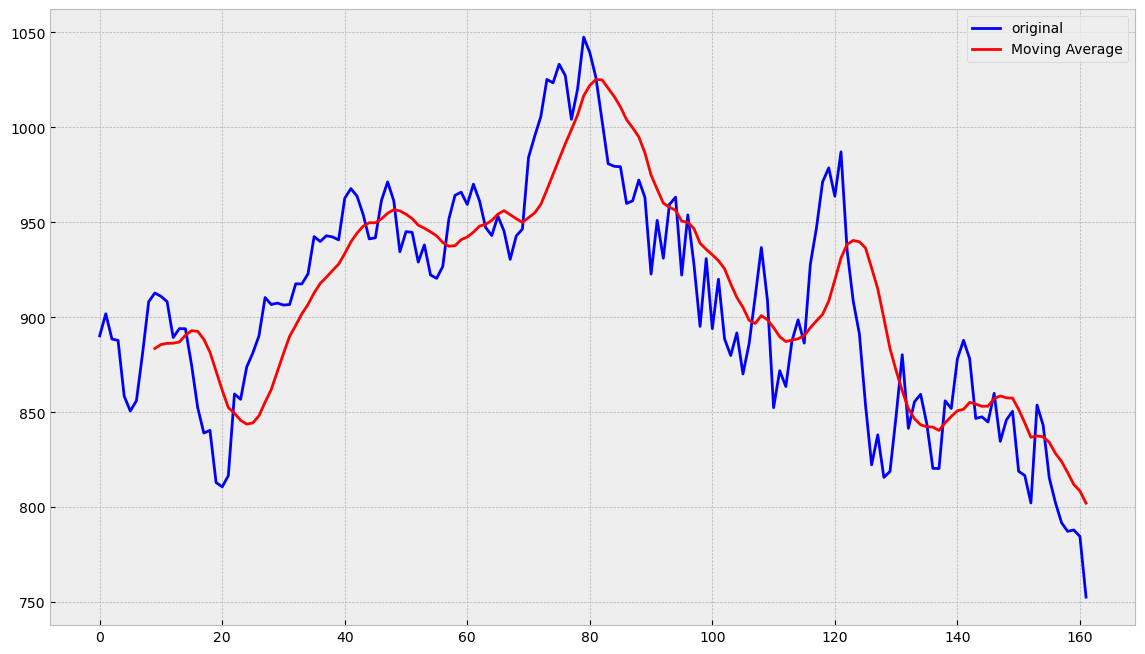

In [13]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue', label='original')
    plt.plot(ma_series, color='red', linewidth='2', label='Moving Average')
    plt.legend()

MA просто усредняет ряд, попробуем предсказать будущие значения

In [14]:
def predict(series, N, n_pred):
    new_series = series.copy()
    for _ in range(n_pred):
        new_series = new_series.append(pd.Series([new_series[-N:].mean()]), ignore_index=True)
    return new_series

In [15]:
ma_series_prediction = predict(series, 10, 50)

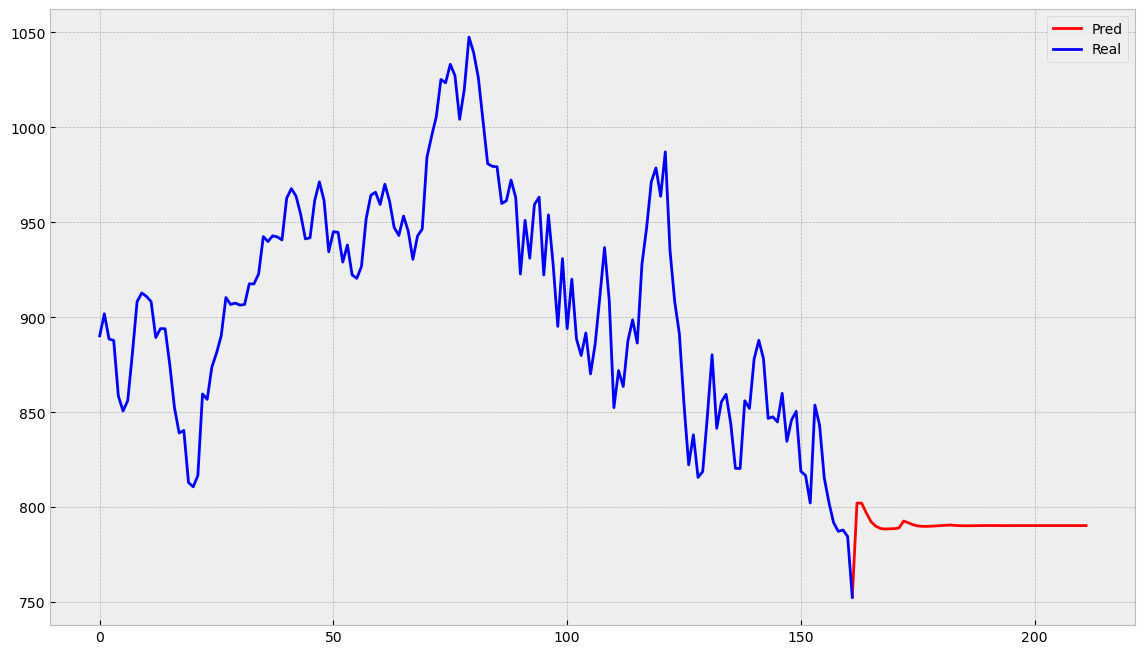

In [16]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(ma_series_prediction[161:], color='red', linewidth='2', label='Pred')
    plt.plot(series, color='blue', linewidth='2', label='Real')
    plt.legend()

Чем больше размер "окна" скользящего среднего $n$ тем более сглаженным получается результат

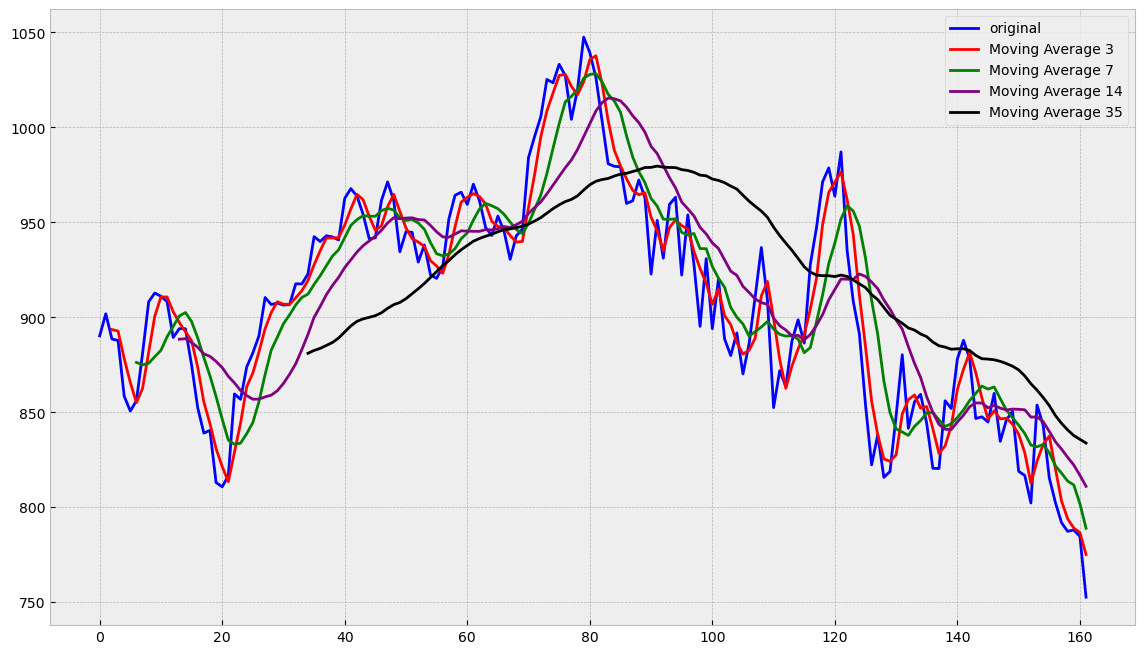

In [17]:
windows = [3, 7, 14, 35]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    for i in range(len(windows)):
        ser = moving_average(series, windows[i])
        plt.plot(ser, color=colors[i], linewidth='2', label='Moving Average {}'.format(windows[i]))
    plt.legend()

Характерная особенность обычного скользящего среднего - повышенная чувствительность к выбросам данных

# Взвешенное скользящее среднее (WMA)
Модификацией обычной скользящей средней является взвешенная скользящая средняя.

$\hat{y}_{t} = \displaystyle\sum^{k}_{n=1} \omega_n y_{t+1-n}$

$\displaystyle\sum^{k}_{n=1} {\omega_n} = 1$

Обычно чем ближе измерение к прогнозируемому - тем больше его вес

In [18]:
def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

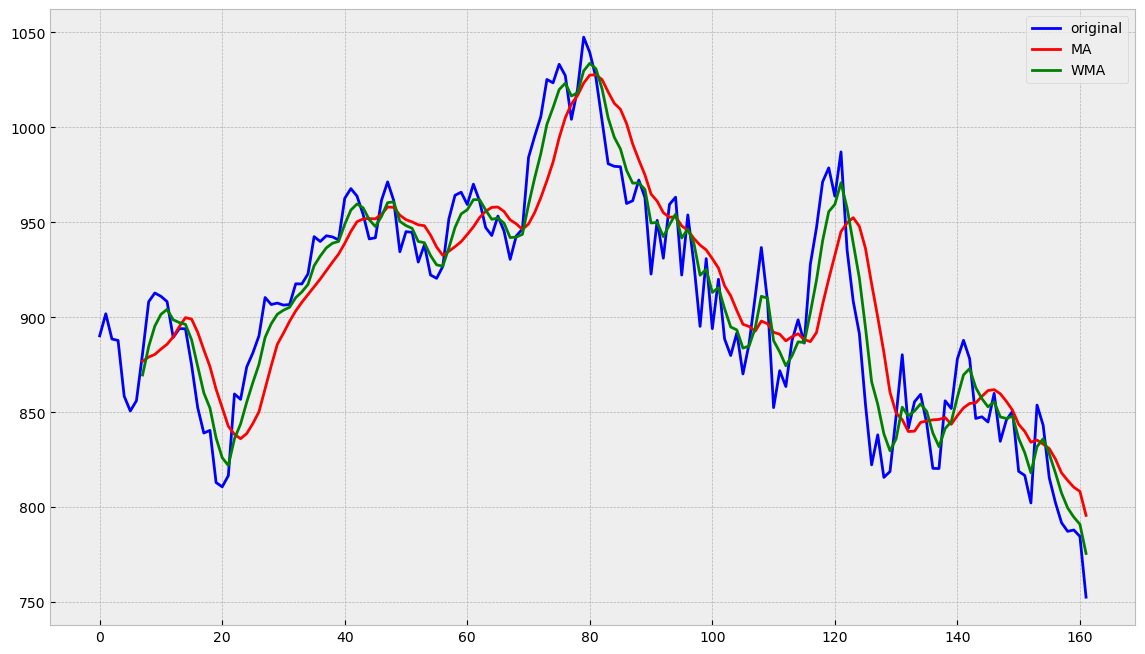

In [50]:
wma_series = weighted_moving_average(series, 8, [1,1,2,3,5,8,13,21])
ma_series = moving_average(series, 8)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    plt.plot(ma_series, color='red', linewidth='2', label='MA')
    plt.plot(wma_series, color='green', linewidth='2', label='WMA')
    plt.legend()

Такая вариация moving average позволяет учитывать временной контекст. Чем раньше было событие - тем меньше оно влияет на прогнозируемое событие

# Экспоненциальное сглаживание (EMA)
Продолжаем развивать идею с историей. Мы хотим на самом деле учитывать не какой-то фиксированный набор измерений. В идеале - мы хотим учитывать всю историю измерений, накопившуюся к текущему моменту. Просто, как и в случае WMA, чем дальше измерение - тем меньше вклад. Для этого используется экспоненциальное скользящее среднее:

$$\hat{y}_{t} = \alpha \cdot y_t + (1-\alpha) \cdot \hat y_{t-1} $$

В нем предсказанное значение - это взвешеное срденее между последним наблюдением и предыдущей историей. Легко заметить, что формула рекурсивна. Параметр $\alpha$ называется сглаживающим фактором. Он определяет, как сильно мы будем опираться на историю (чем меньше - тем больше). Чем меньше $\alpha$, тем больше влияния оказывают предыдущие предсказанные значения, и тем сильнее сглаживается ряд. 

In [21]:
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

In [22]:
ema_series = exponential_moving_average(series, 0.7)

In [23]:
len(ema_series)

162

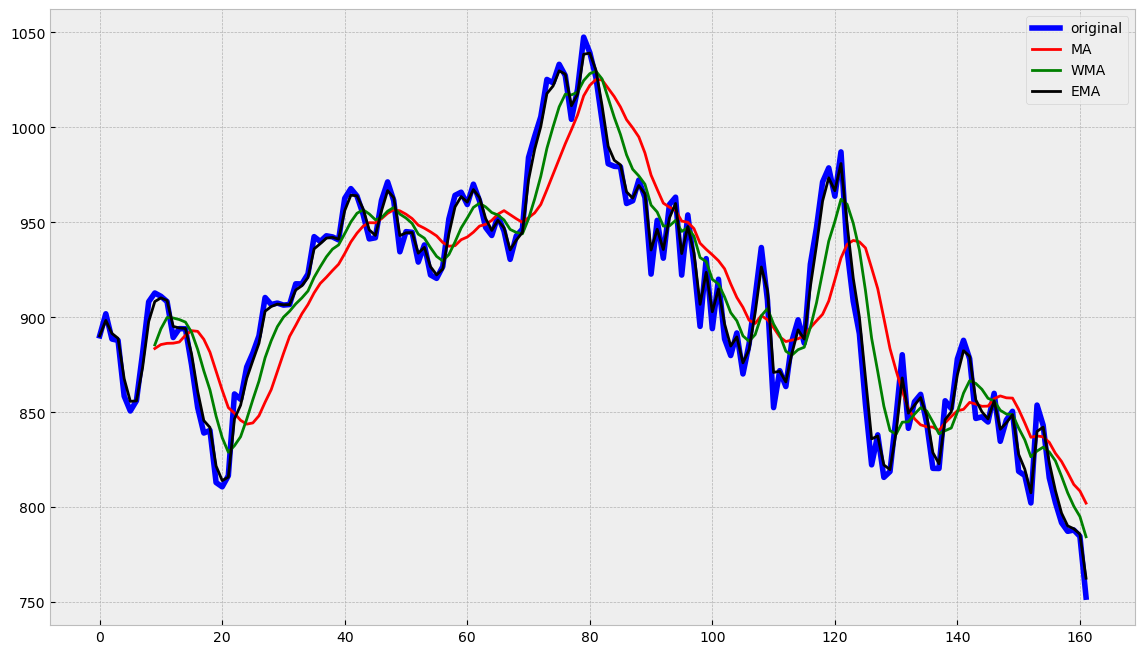

In [24]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue', linewidth='4', label='original')
    plt.plot(ma_series, color='red', linewidth='2', label='MA')
    plt.plot(wma_series, color='green', linewidth='2', label='WMA')
    plt.plot(ema_series, color='black', linewidth='2', label='EMA')
    plt.legend()

Посмотрим, как влияет значение альфы на получившийся сглаженный временной ряд

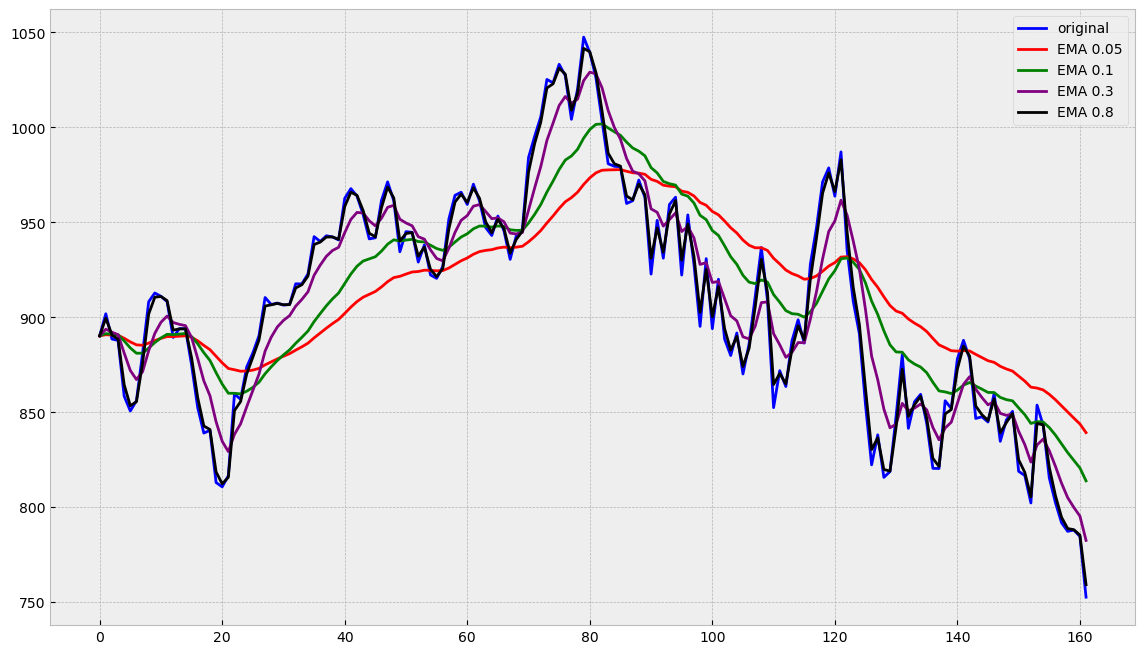

In [25]:
alphas = [0.05, 0.1, 0.3, 0.8]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    for i in range(len(alphas)):
        ser = exponential_moving_average(series, alphas[i])
        plt.plot(ser, color=colors[i], linewidth='2', label='EMA {}'.format(alphas[i]))
    plt.legend()

Чем ближе альфа к 1, тем больше алгоритм обращает внимание на недавние значения

# Двойное экспоненциальное сглаживание (DEMA)
$$\hat{y}_t=l_t + s_t$$
$$\hat{y}_t=\alpha y_t + (1-\alpha)\hat{y}_{t-1}$$
$$\hat{l}_t = \alpha y_t + (1-\alpha)(l_{t-1} + s_{t-1})$$
До сих пор мы рассматривали ряд - как единую составляющую. Но на самом деле, ряд $y_t$ можно представить в виде суммы $l_t$ (уровня) и $s_t$ (тренда). По сути - тренд - это основное направление движения ряда, а уровень - колебание вокруг этого тренда.

Для предсказания уровня мы используем подход на основе классического EMA:

$l_t = \alpha y_t + (1-\alpha)(l_{t-1} + s_{t-1})$

Для прогноза тренда используем так же EMA и простое соображение: историческое значение тренда - это историческое значение тренда, а текущее значение тренда - это изменение уровня. Получим такую формулу:

$s_t = \beta (l_t - l_{t-1}) + (1 - \beta) s_{t-1}$

Итоговый ряд предсказываем по следующей формуле

$\hat{y}_{t+1} = l_t + s_t$

In [26]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

In [27]:
def plot_dema(alpha, beta):
    dema = double_ema(series, alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(series, color='blue',label='original')
        plt.plot(dema, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

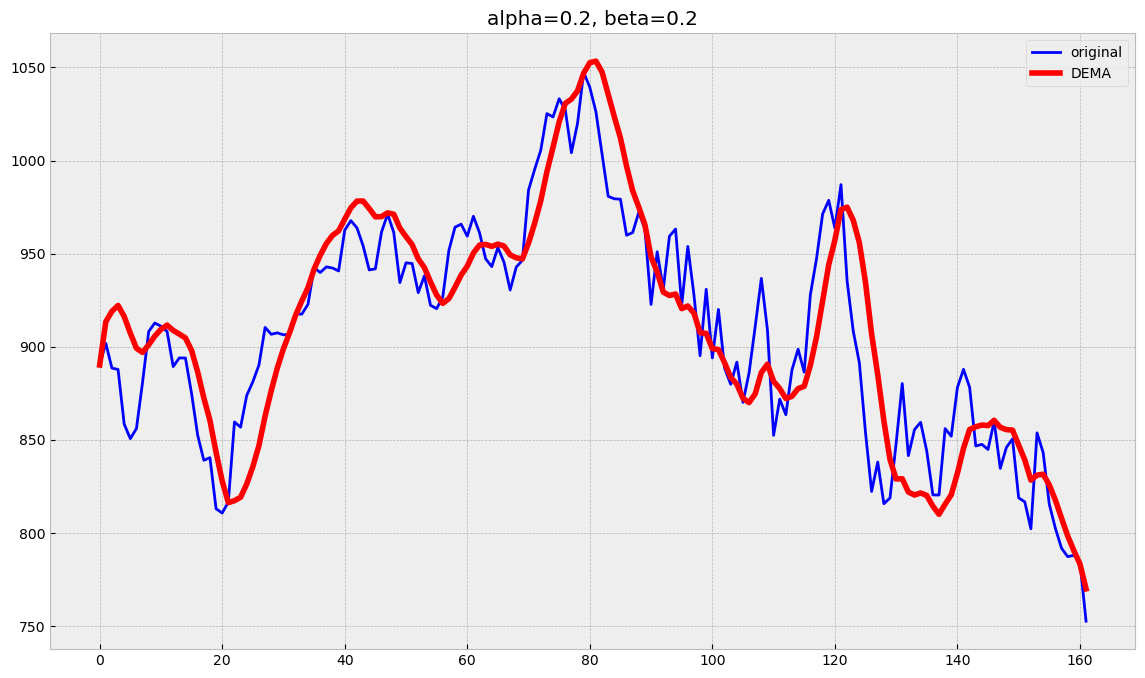

In [28]:
plot_dema(0.2, 0.2)

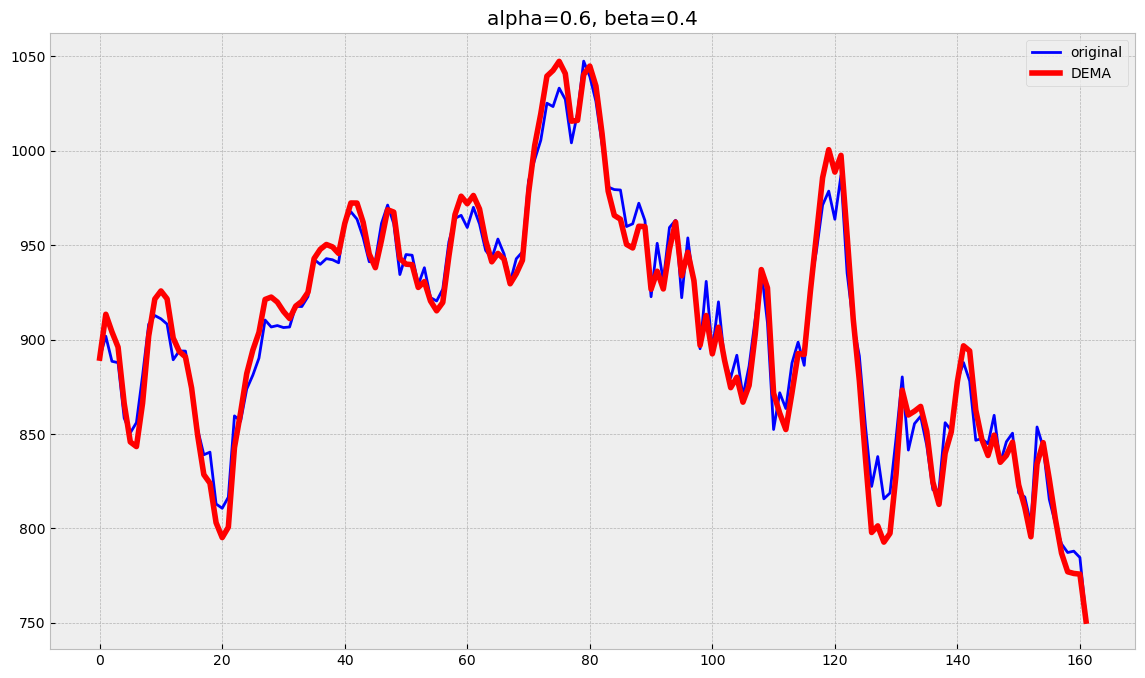

In [29]:
plot_dema(0.6, 0.4)

Как мы видим, настройка параметров $\alpha$ и $\beta$ очень важна.   
$\alpha$ отвечает за сглаживание ряда вокруг тренда, $\beta$ - за сглаживание самого тренда. Чем больше значения, тем более значимыми будут последние наблюдения и менее значимой будет история. Но данный метод все еще плохо предсказывает будущее и предсказания будут просто линейны, так как мы учитываем только тренд.

In [30]:
def double_ema_with_preds(series, alpha, beta, n_preds):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)

    preds = []
    for n in range(n_preds):
        value = result[-1]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        preds.append(level+trend)

    return series.append(pd.Series(preds), ignore_index=True), pd.Series(result)

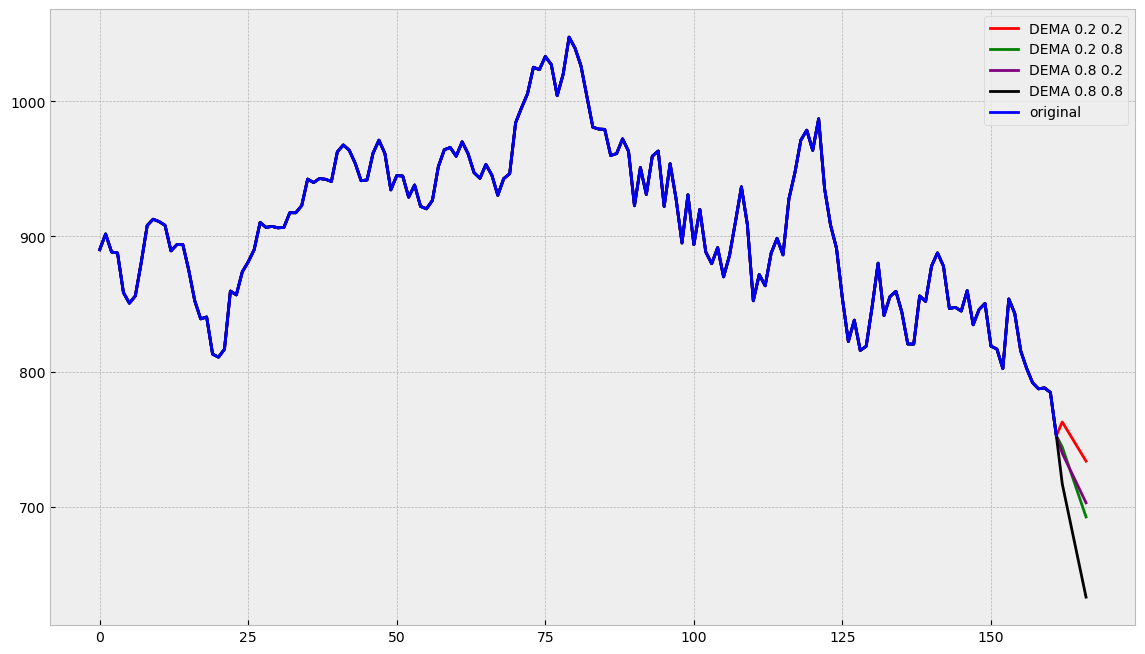

In [31]:
alphas = [0.2,0.2,0.8,0.8]
bettas = [0.2,0.8,0.2,0.8]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    for i in range(len(alphas)):
        ser, _ = double_ema_with_preds(series, alphas[i], bettas[i], 5)
        plt.plot(ser, color=colors[i], linewidth='2', label='DEMA {} {}'.format(alphas[i], bettas[i]))
    plt.plot(series, color='blue',label='original')
    plt.legend()

# Тройное экспоненциальное сглаживание. Метод Хольта-Винтерса (TEMA)
Суть метода в том, что начинаем еще учитывать сезонность. Она учитывается в виде третьей компоненты.

**Важно** - метод применим только в случае сезонности. Если ее нет - метод хольта-винтерса не даст хороших результатов;

$l_t = \alpha(y_t - p_{t-\tau}) + (1-\alpha)(l_{t-1} + s_{t-1})$


$s_t = \beta(l_t - l_{t-1}) + (1-\beta)s_{t-1}$

$p_t = \gamma(y_t - l_t) + (1-\gamma)p_{t-\tau}$

$\hat{y}_{t+m} = l_x + s_t + p_{t-\tau+1+(m-1)mod\tau}$

Сезонная компонента $p_t$ объясняет повторяющиеся колебания вокруг уровня и тренда; ее параметр - период, после которого начинаются повторения колебаний. Для каждого наблюдения в сезоне формируется своя компонента, например, если длина сезона составляет 3, то мы получим 3 сезонные компоненты.

В уровене из значения ряда теперь вычитается сезонная компонента;

Тренд остаётся без изменений;

Сезонная компонента зависит от текущего значения ряда за вычетом уровня и от предыдущего значения компоненты.

**При сглаживании сезонной компоненты - она сглаживается только со своими измерениями**

In [32]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [33]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [34]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [35]:
def plot_tema(alpha, beta, gamma, ser=series, ser_to_plot=series, n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

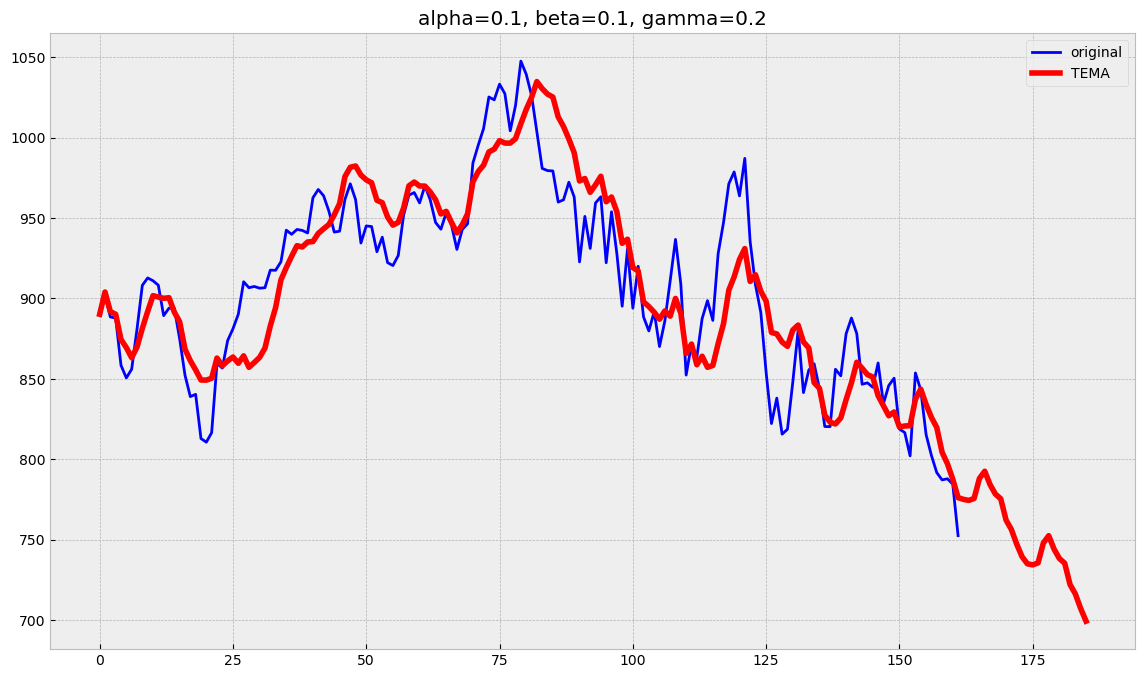

In [36]:
plot_tema(0.1, 0.1, 0.2)

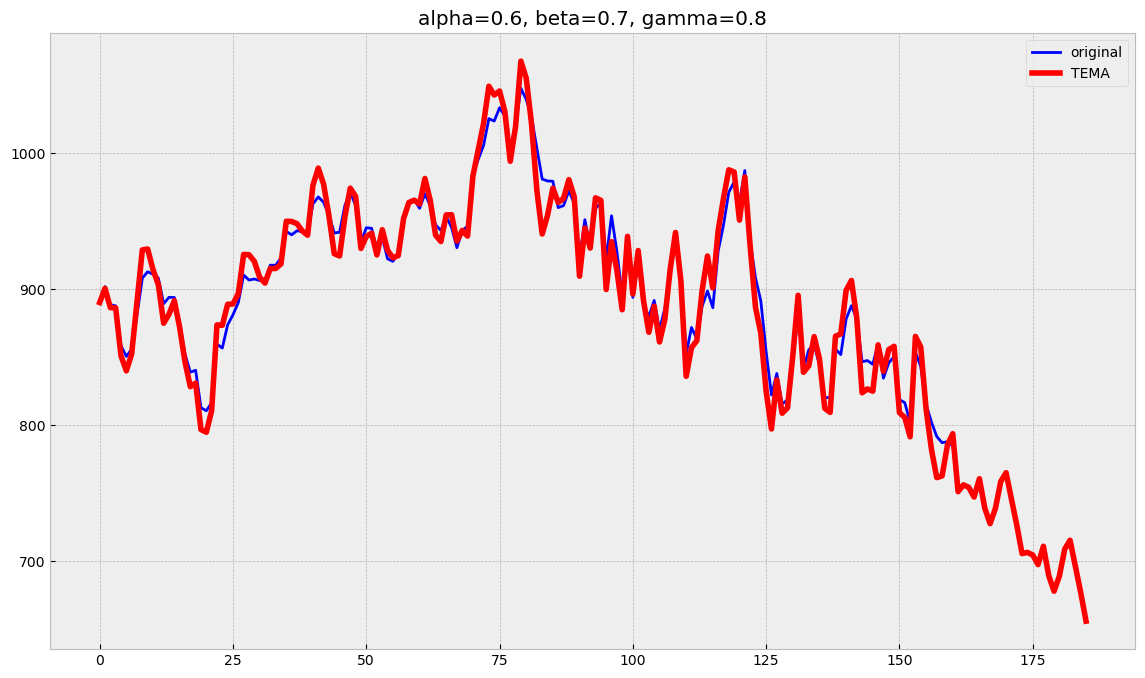

In [37]:
plot_tema(0.6, 0.7, 0.8)

Что значит, что наша модель лучше всего приближает исходные данные? Это значит, что минимизируется некоторая функция ошибки. Мы, для простоты, будет считать стандарнтый RMSE:

$RMSE =  \sqrt {1/n \sum^N_{i=1} (\hat{y}_i - y_i)^2}$

Алгоритм поиска стандартный - метод градиентного спуска. Считаем производный по каждому из параметров и спускаемся в сторону минимума.

In [38]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [39]:
train, test, val = series[:140], series[140:150], series[150:]

In [40]:
val.shape

(12,)

In [41]:
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 5, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [42]:

opt = minimize(mse, x0=np.array([0,0,0]), method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [43]:
alpha_opt, beta_opt, gamma_opt = opt.x
print('hello world hello', opt)

hello world hello   message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 338.3765998446011
        x: [ 1.000e+00  6.848e-03  1.000e+00]
      nit: 8
      jac: [-2.243e+02  7.390e-05 -0.000e+00]
     nfev: 36
     njev: 9
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


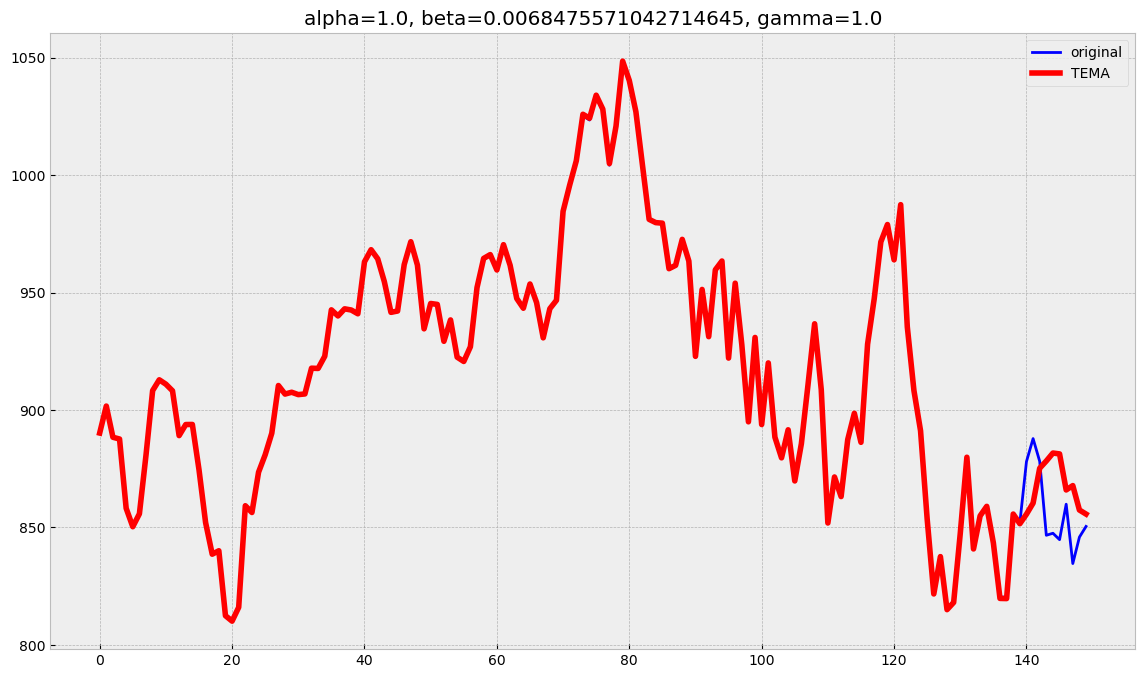

In [44]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series[:150], n_preds=len(test))

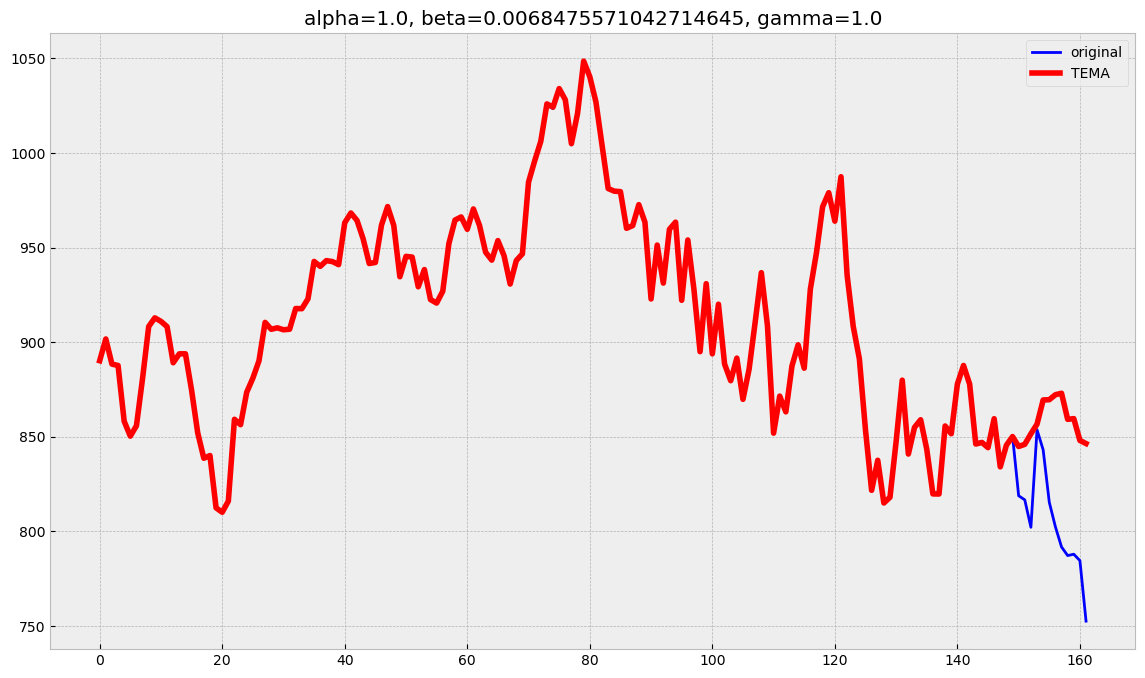

In [45]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=series[:150], ser_to_plot=series, n_preds=len(val))

В данном ряде нет сезонности, поэтому прогноз получился не такой, каким бы нам хотелось его видеть. Метод Хольта-Винтерса применим только в случае сезонности. ЕСли ее нет, то метод не даст хороших результатов. 

# Стационарный ряд

Results of Dickey-Fuller Test:
Test Statistic                -1.302521e+01
p-value                        2.407586e-24
#Lags Used                     0.000000e+00
Number of Observations Used    1.600000e+02
Critical Value (1%)           -3.471896e+00
Critical Value (5%)           -2.879780e+00
Critical Value (10%)          -2.576495e+00
dtype: float64


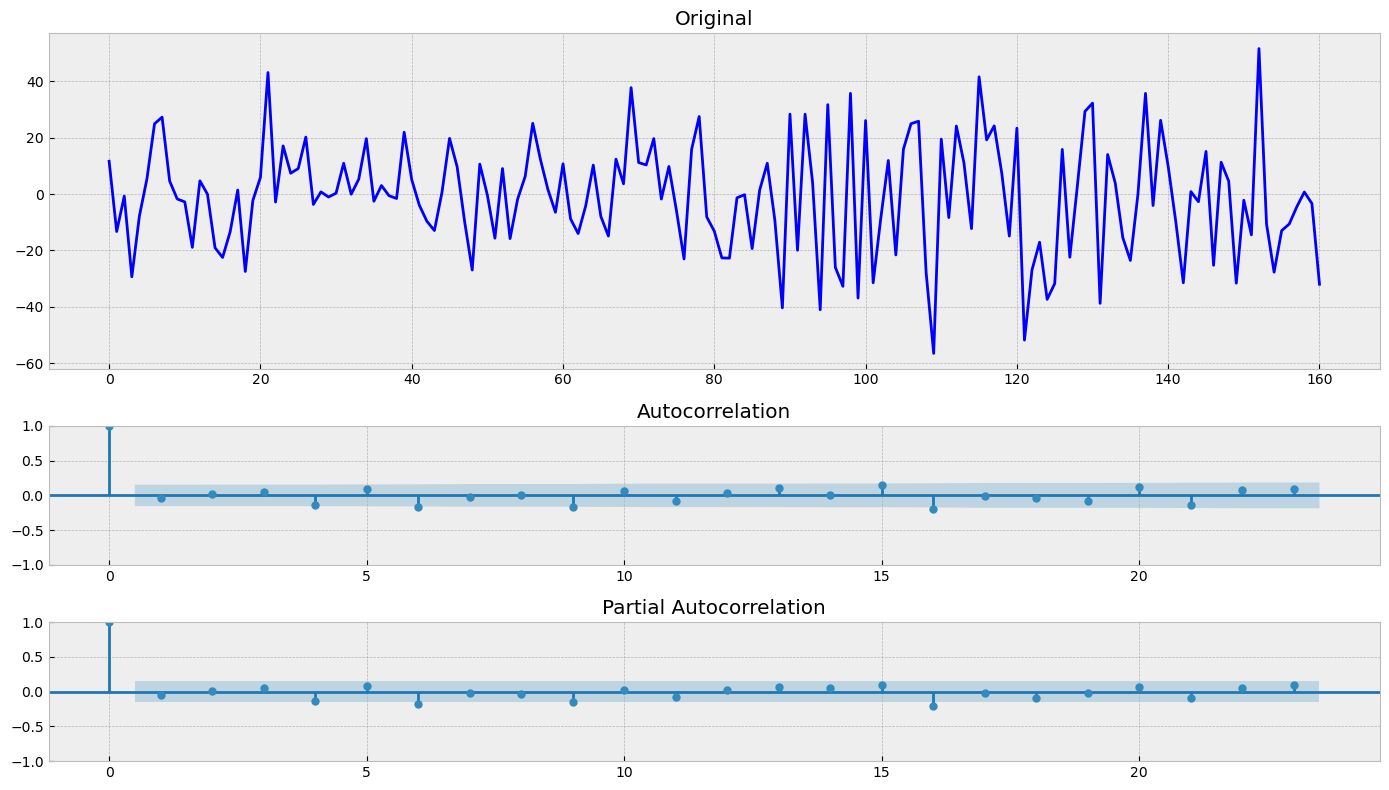

In [46]:
tsplot(stat_series)

# Скользящее среднее

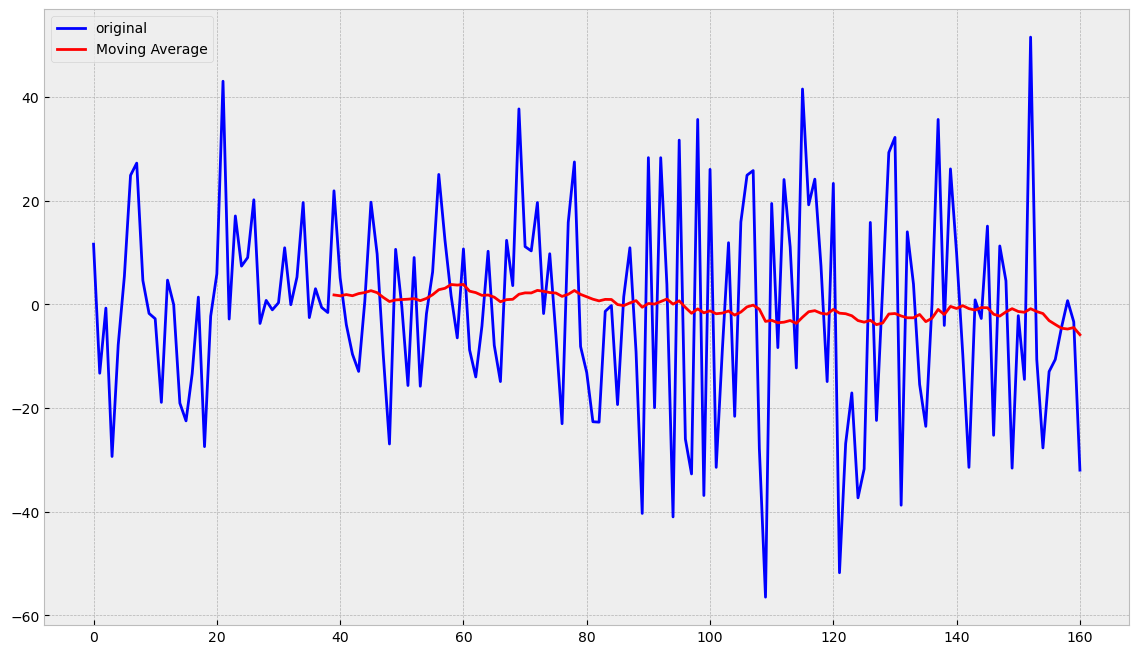

In [55]:
ma_stat_series = moving_average(stat_series, 40)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(stat_series, color='blue', label='original')
    plt.plot(ma_stat_series, color='red', linewidth='2', label='Moving Average')
    plt.legend()

# Взвешенное скользящее среднее (WMA)

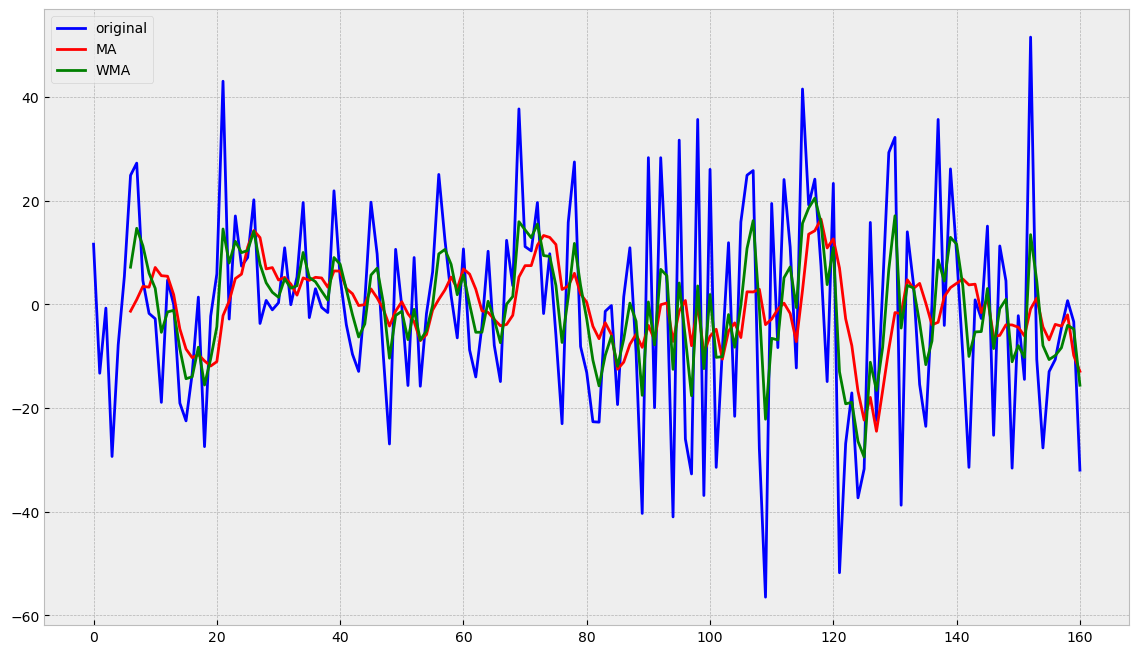

In [49]:
wma_stat_series = weighted_moving_average(stat_series, 7, [1,1,2,3,5,8,13])
ma_stat_series = moving_average(stat_series, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(stat_series, color='blue',label='original')
    plt.plot(ma_stat_series, color='red', linewidth='2', label='MA')
    plt.plot(wma_stat_series, color='green', linewidth='2', label='WMA')
    plt.legend()

# Двойное экспоненциальное сглаживание

In [52]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

In [53]:
def plot_dema(ser, alpha, beta):
    dema = double_ema(ser, alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser, color='blue',label='original')
        plt.plot(dema, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

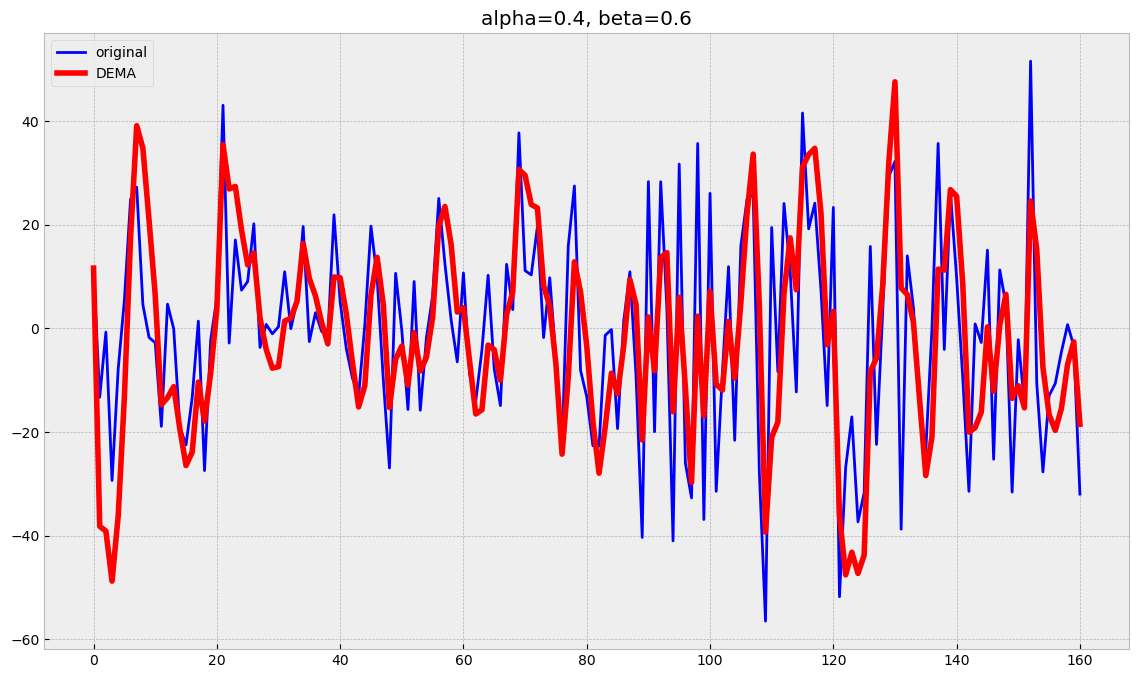

In [59]:
plot_dema(stat_series, 0.4, 0.6)

# Хольт-Винтерс

In [67]:
def plot_tema(alpha, beta, gamma, ser=stat_series, ser_to_plot=stat_series, n_preds=24):
    tema = triple_exponential_smoothing(ser, 6, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

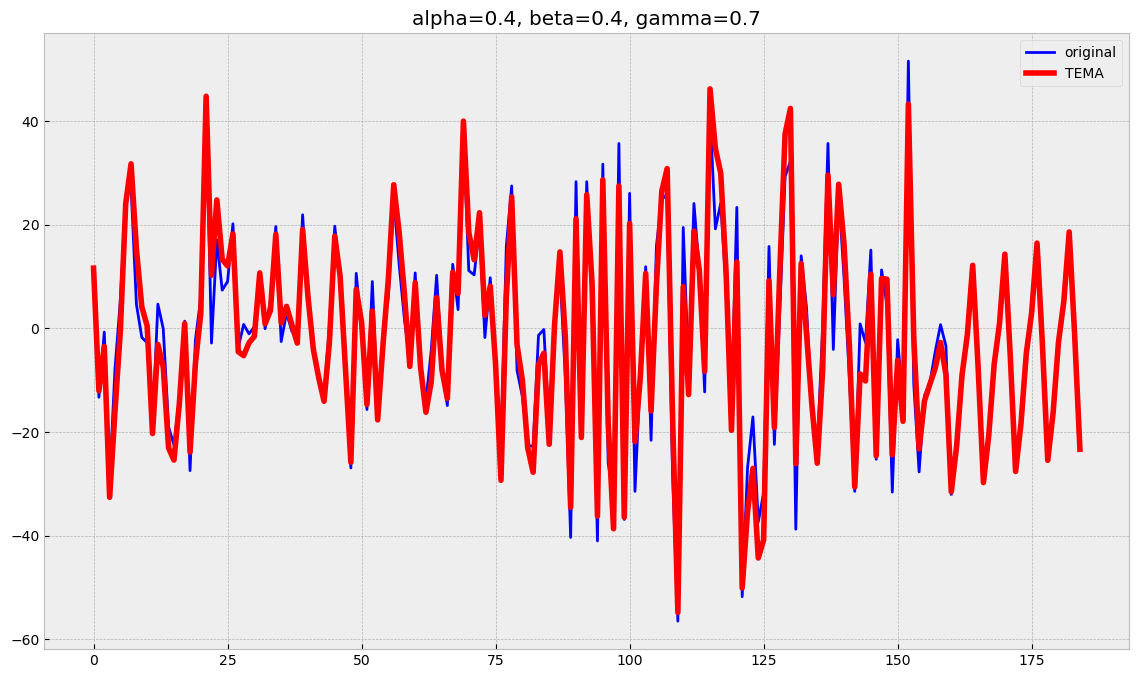

In [76]:
plot_tema(0.4, 0.4, 0.7)

Таким образом были рассмотрены различные модели сглаживания временного ряда. У каждого из методов есть свои преймущества и недостатки.   
Скользящее среднее достаточно прост в реализации, но использует n-значений в прошлом из-за чего новый ряд будет начинаться "с отставанием" (на n-значений по которым происходят вычисления. К тому же если пробовать предсказывать ряд в будущем, то предскажутся только n значений, а дальше будет ряд из константы.  
Взвешенное скользящее среднее очень похоже на обычное скользящее с учетом того, что у каждого значения в прошлом есть свой вес.   
Двойное экспоненциальное сглаживание учитывает временной контекст и тренд.  
Тройное экспоненциальное сглаживание учитывает еще и сезонность, помимо временного контекста и тренда. Однако если сезонности нет, то данный метод не будет хорошо работать.  
Для временного ряда в данном ноутбуке лучшим оказался метод двойного экспоненциального сглаживания, так как ряд не имеет сезонности, а только тренд из характеристик. 